# IMPORTS

In [1]:
#importing relevant libraries

import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit    #for fitting an exponential
import functools as fnt
from textwrap import wrap

# CONSTANTS

In [2]:
#relevant constants
pc = 3.086e18                   #cm
pi = np.pi

#galaxy specific constants (taken from SS21_ch11)
R = 10*(10**3)*pc           #radius in cm
omega = 6.481*(10**(-18))   #angular velocity in s^-1
h = 0.5*(10**3)*pc          #height in cm
eta_T = 10**26              #Diffusion coefficient in cm^2 s^-1
to = h*h/eta_T              #diffusion time in s
print('time stepping is normalised to to(s) = ', to)

time stepping is normalised to to(s) =  2.380849e+16


# DIFFERENTIAL EQUATIONS

In [3]:
def Br_diff(t, Br, Bp, r_ind, dz, alpha):                          #for both alpha-omega and alpha-square omega dynamo

    dBr_dt = np.array(-1*(0)*(-3*Bp[0] + 4*Bp[1] - Bp[2])/(2*dz) + (2*Br[0] - 5*Br[1] + 4*Br[2] - Br[3])/(dz**2))                           #for boundary
    dBr_dt = np.append(dBr_dt, -1*alpha[r_ind]*np.array(Bp[2:] - Bp[:-2])/(2*dz) + np.array(Br[:-2] + Br[2:] - 2*Br[1:-1])/(dz**2))         #for interior
    dBr_dt = np.append(dBr_dt, -1*alpha[r_ind]*(3*Bp[-1] - 4*Bp[-2] + Bp[-3])/(2*dz) + (2*Br[-1] - 5*Br[-2] + 4*Br[-3] - Br[-4])/(dz**2))   #for boundary
    return dBr_dt

def Bp_diff(t, Br, Bp, r_ind, dz, alpha, S, D, Ralpha, ao = True):     

    if ao:          #for alpha-omega dynamo 
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2) )                                               #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))                         #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))                                   #for boundary
    else:           #for alpha-square omega dynamo
        dBp_dt = np.array( D*S[r_ind]*Br[0] + (Ralpha**2)*alpha[r_ind]*(-3*Br[0] + 4*Br[1] - Br[2])/(2*dz) + (2*Bp[0] - 5*Bp[1] + 4*Bp[2] - Bp[3])/(dz**2))                         #for boundary
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*np.array(Br[1:-1]) + (Ralpha**2)*alpha[r_ind]*np.array(Br[2:] - Br[:-2])/(2*dz) + np.array(Bp[:-2] + Bp[2:] - 2*Bp[1:-1])/(dz**2))    #for interior
        dBp_dt = np.append(dBp_dt, D*S[r_ind]*Br[-1] + (Ralpha**2)*alpha[r_ind]*(3*Br[-1] - 4*Br[-2] + Br[-3])/(2*dz) + (2*Bp[-1] - 5*Bp[-2] + 4*Bp[-3] - Bp[-4])/(dz**2))          #for boundary
    
    return dBp_dt

# RUNGE KUTTA (4TH ORDER)

### For Dirichlet Boundary Conditions
These boundary conditions specify that the time evolution of the boundary values is fixed to some number.

### For Neumann Boundary Conditions
These boundary conditions specify that the spatial derivatives of the function values are some number at the boundary.

This Runge-Kutta code solves a general system of differential equations in two variables(since in our case we have Br and Bphi)

In [4]:
def rk4(F, G, X, Y, BX0, BXn, BY0, BYn, t, dt, dz, bc = 'dir'):
    #F is the function for the time evolution of X, in our case Br
    #G is the function for the time evolution of Y, in our case Bp
    #X is the array of X values
    #Y is the array of Y values
    #t is the current time
    #dt is the time step
    #dz is the spatial step
    #bc is the boundary condition type
    #BX0, BY0, BXn, BYn are the boundary values

    #We know the time evolution of the borders
    #So we only need to solve for the interior

    #let len(X) = len(Y) = n
    #Assigning the first boundary value
    if bc == 'dir':
        X_new = np.array([BX0])
        Y_new = np.array([BY0])
    elif bc == 'neu':
        X_new = np.array([4*X[1]/3 - X[2]/3 - 2*dz*BX0/3])
        Y_new = np.array([4*Y[1]/3 - Y[2]/3 - 2*dz*BY0/3])

    #Solving the runge kutta coefficients
    k1 = F(t, X, Y)                                     #len = n
    l1 = G(t, X, Y)                                     #len = n

    k2 = F(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n        
    l2 = G(t + dt/2, X + k1*dt/2, Y + l1*dt/2)          #len = n

    k3 = F(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n
    l3 = G(t + dt/2, X + k2*dt/2, Y + l2*dt/2)          #len = n

    k4 = F(t + dt, X + k3*dt, Y + l3*dt)                #len = n
    l4 = G(t + dt, X + k3*dt, Y + l3*dt)                #len = n

    #Assigning the interior values
    X_new = np.append(X_new, X[1:-1] + np.array(k1 + 2*k2 + 2*k3 + k4)[1:-1]*dt/6)
    Y_new = np.append(Y_new, Y[1:-1] + np.array(l1 + 2*l2 + 2*l3 + l4)[1:-1]*dt/6)

    #Assigning the last boundary value
    if bc == 'dir':
        X_new = np.append(X_new, BXn)        
        Y_new = np.append(Y_new, BYn)
    elif bc == 'neu':
        X_new = np.append(X_new, 4*X[-2]/3 - X[-3]/3 + 2*dz*BXn/3)
        Y_new = np.append(Y_new, 4*Y[-2]/3 - Y[-3]/3 + 2*dz*BYn/3)

    return X_new, Y_new

# 

In [5]:
#defining the grid and timestepping

#grid parameters
z_res = 2*10**2                 #resolution
r_res = 2*10**1                 #resolution
z0 = -1                         #lower z/h limit
zn = 1                          #upper z/h limit
r0 = 0.001                      #lower r/R limit
rn = 1                          #upper r/R limit
dz = (zn-z0)/z_res              #step size
dr = (rn-r0)/r_res              #step size
z = np.linspace(z0, zn, z_res)  #normalised to scale height h
r = np.linspace(r0, rn, r_res)  #normalised to radius R

#time parameters
dt = 0.000049
t0 = 0

print('dt/to =', dt, 'and dz =', dz)
print('The solution is stable when 2*dt/(dz**2) =', 2*dt/(dz**2), '< 1')

dt/to = 4.9e-05 and dz = 0.01
The solution is stable when 2*dt/(dz**2) = 0.9799999999999999 < 1


In [35]:
#constants and other known variables (0 for the diffusion equation)
l0 = 0.1*(10**2)*pc                     #in cm
V0 = 2*10**7                            #in cm/s
omega0 = V0/R                           #in s^-1
alpha0 = (l0**2)*omega0/h               #normalised to l0**2 omega0/h
S0 = -omega0                            #normalised to 1/r

alpha = np.repeat(1, r_res)             #normalised to alpha0 = l0**2 omega0/h
S = 1/r                                 #normalised to S0 = -omega0
D1 = -1
Ralpha = 1                              #Some dummy value, not used in alpha-omega dynamo
r_ind = np.where(r >= 0.2)[0][0]        #Pick r where r/R around 0.2

#Initial seed fields
Br1 = np.cos(pi*z/2)
Bp1 = np.cos(pi*z/2)
Br2 = (np.cos(pi*z/2))**2 + (np.cos(3*pi*z/2))**2
Bp2 = (np.cos(pi*z/2))**2 + (np.cos(3*pi*z/2))**2
Br3 = np.sin(pi*z)       
Bp3 = np.sin(pi*z)

#Dirichlet boundary conditions
Br1_0 = 0
Br1_n = 0
Bp1_0 = 0
Bp1_n = 0

Br2_0 = 0
Br2_n = 0
Bp2_0 = 0
Bp2_n = 0

Br3_0 = 0
Br3_n = 0
Bp3_0 = 0
Bp3_n = 0

#Removing function dependence on known values by specifying them
Br_diff_eq = fnt.partial(Br_diff, r_ind = r_ind, dz = dz, alpha = alpha)
Bp_diff_eq1 = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, D=-1, Ralpha = Ralpha, ao = True)
Bp_diff_eq2 = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, D=-15, Ralpha = Ralpha, ao = True)
Bp_diff_eq3 = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, D=-10, Ralpha = Ralpha, ao = True)
Bp_diff_eq4 = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, D=-8, Ralpha = Ralpha, ao = True)
Bp_diff_eq5 = fnt.partial(Bp_diff, r_ind = r_ind, dz = dz, alpha = alpha, S = S, D=-6, Ralpha = Ralpha, ao = True)

In [7]:
#initialising the solutions
Br1_sol1 = np.array([Br1])
Bp1_sol1 = np.array([Bp1])

Br2_sol1 = np.array([Br2])
Bp2_sol1 = np.array([Bp2])

Br3_sol1 = np.array([Br3])
Bp3_sol1 = np.array([Bp3])

t = np.array([t0])

steps= 3*10**4
for i in range(steps):

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq1, Br1_sol1[-1], Bp1_sol1[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br1_sol1 = np.append(Br1_sol1, [Br_temp], axis = 0)
    Bp1_sol1 = np.append(Bp1_sol1, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq1, Br2_sol1[-1], Bp2_sol1[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br2_sol1 = np.append(Br2_sol1, [Br_temp], axis = 0)
    Bp2_sol1 = np.append(Bp2_sol1, [Bp_temp], axis = 0) 

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq1, Br3_sol1[-1], Bp3_sol1[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br3_sol1 = np.append(Br3_sol1, [Br_temp], axis = 0)
    Bp3_sol1 = np.append(Bp3_sol1, [Bp_temp], axis = 0)

    t = np.append(t, t[-1] + dt)

In [12]:
#initialising the solutions
Br1_sol2 = np.array([Br1])
Bp1_sol2 = np.array([Bp1])

Br2_sol2 = np.array([Br2])
Bp2_sol2 = np.array([Bp2])

Br3_sol2 = np.array([Br3])
Bp3_sol2 = np.array([Bp3])

t = np.array([t0])

steps= 3*10**4
for i in range(steps):

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq2, Br1_sol2[-1], Bp1_sol2[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br1_sol2 = np.append(Br1_sol2, [Br_temp], axis = 0)
    Bp1_sol2 = np.append(Bp1_sol2, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq2, Br2_sol2[-1], Bp2_sol2[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br2_sol2 = np.append(Br2_sol2, [Br_temp], axis = 0)
    Bp2_sol2 = np.append(Bp2_sol2, [Bp_temp], axis = 0) 

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq2, Br3_sol2[-1], Bp3_sol2[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br3_sol2 = np.append(Br3_sol2, [Br_temp], axis = 0)
    Bp3_sol2 = np.append(Bp3_sol2, [Bp_temp], axis = 0)

    t = np.append(t, t[-1] + dt)

In [30]:
#initialising the solutions
Br1_sol3 = np.array([Br1])
Bp1_sol3 = np.array([Bp1])

Br2_sol3 = np.array([Br2])
Bp2_sol3 = np.array([Bp2])

Br3_sol3 = np.array([Br3])
Bp3_sol3 = np.array([Bp3])

t = np.array([t0])

steps= 3*10**4
for i in range(steps):

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq3, Br1_sol3[-1], Bp1_sol3[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br1_sol3 = np.append(Br1_sol3, [Br_temp], axis = 0)
    Bp1_sol3 = np.append(Bp1_sol3, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq3, Br2_sol3[-1], Bp2_sol3[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br2_sol3 = np.append(Br2_sol3, [Br_temp], axis = 0)
    Bp2_sol3 = np.append(Bp2_sol3, [Bp_temp], axis = 0) 

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq3, Br3_sol3[-1], Bp3_sol3[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br3_sol3 = np.append(Br3_sol3, [Br_temp], axis = 0)
    Bp3_sol3 = np.append(Bp3_sol3, [Bp_temp], axis = 0)

    t = np.append(t, t[-1] + dt)

In [33]:
#initialising the solutions
Br1_sol4 = np.array([Br1])
Bp1_sol4 = np.array([Bp1])

Br2_sol4 = np.array([Br2])
Bp2_sol4 = np.array([Bp2])

Br3_sol4 = np.array([Br3])
Bp3_sol4 = np.array([Bp3])

t = np.array([t0])

steps= 3*10**4
for i in range(steps):

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq4, Br1_sol4[-1], Bp1_sol4[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br1_sol4 = np.append(Br1_sol4, [Br_temp], axis = 0)
    Bp1_sol4 = np.append(Bp1_sol4, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq4, Br2_sol4[-1], Bp2_sol4[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br2_sol4 = np.append(Br2_sol4, [Br_temp], axis = 0)
    Bp2_sol4 = np.append(Bp2_sol4, [Bp_temp], axis = 0) 

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq4, Br3_sol4[-1], Bp3_sol4[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br3_sol4 = np.append(Br3_sol4, [Br_temp], axis = 0)
    Bp3_sol4 = np.append(Bp3_sol4, [Bp_temp], axis = 0)

    t = np.append(t, t[-1] + dt)

In [38]:
#initialising the solutions
Br1_sol5 = np.array([Br1])
Bp1_sol5 = np.array([Bp1])

Br2_sol5 = np.array([Br2])
Bp2_sol5 = np.array([Bp2])

Br3_sol5 = np.array([Br3])
Bp3_sol5 = np.array([Bp3])

t = np.array([t0])

steps= 6*10**4
for i in range(steps):

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq5, Br1_sol5[-1], Bp1_sol5[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br1_sol5 = np.append(Br1_sol5, [Br_temp], axis = 0)
    Bp1_sol5 = np.append(Bp1_sol5, [Bp_temp], axis = 0)

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq5, Br2_sol5[-1], Bp2_sol5[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br2_sol5 = np.append(Br2_sol5, [Br_temp], axis = 0)
    Bp2_sol5 = np.append(Bp2_sol5, [Bp_temp], axis = 0) 

    Br_temp, Bp_temp = rk4(Br_diff_eq, Bp_diff_eq5, Br3_sol5[-1], Bp3_sol5[-1], Br1_0, Br1_n, Bp1_0, Bp1_n, t[-1], dt, dz, bc = 'dir')
    Br3_sol5 = np.append(Br3_sol5, [Br_temp], axis = 0)
    Bp3_sol5 = np.append(Bp3_sol5, [Bp_temp], axis = 0)

    t = np.append(t, t[-1] + dt)

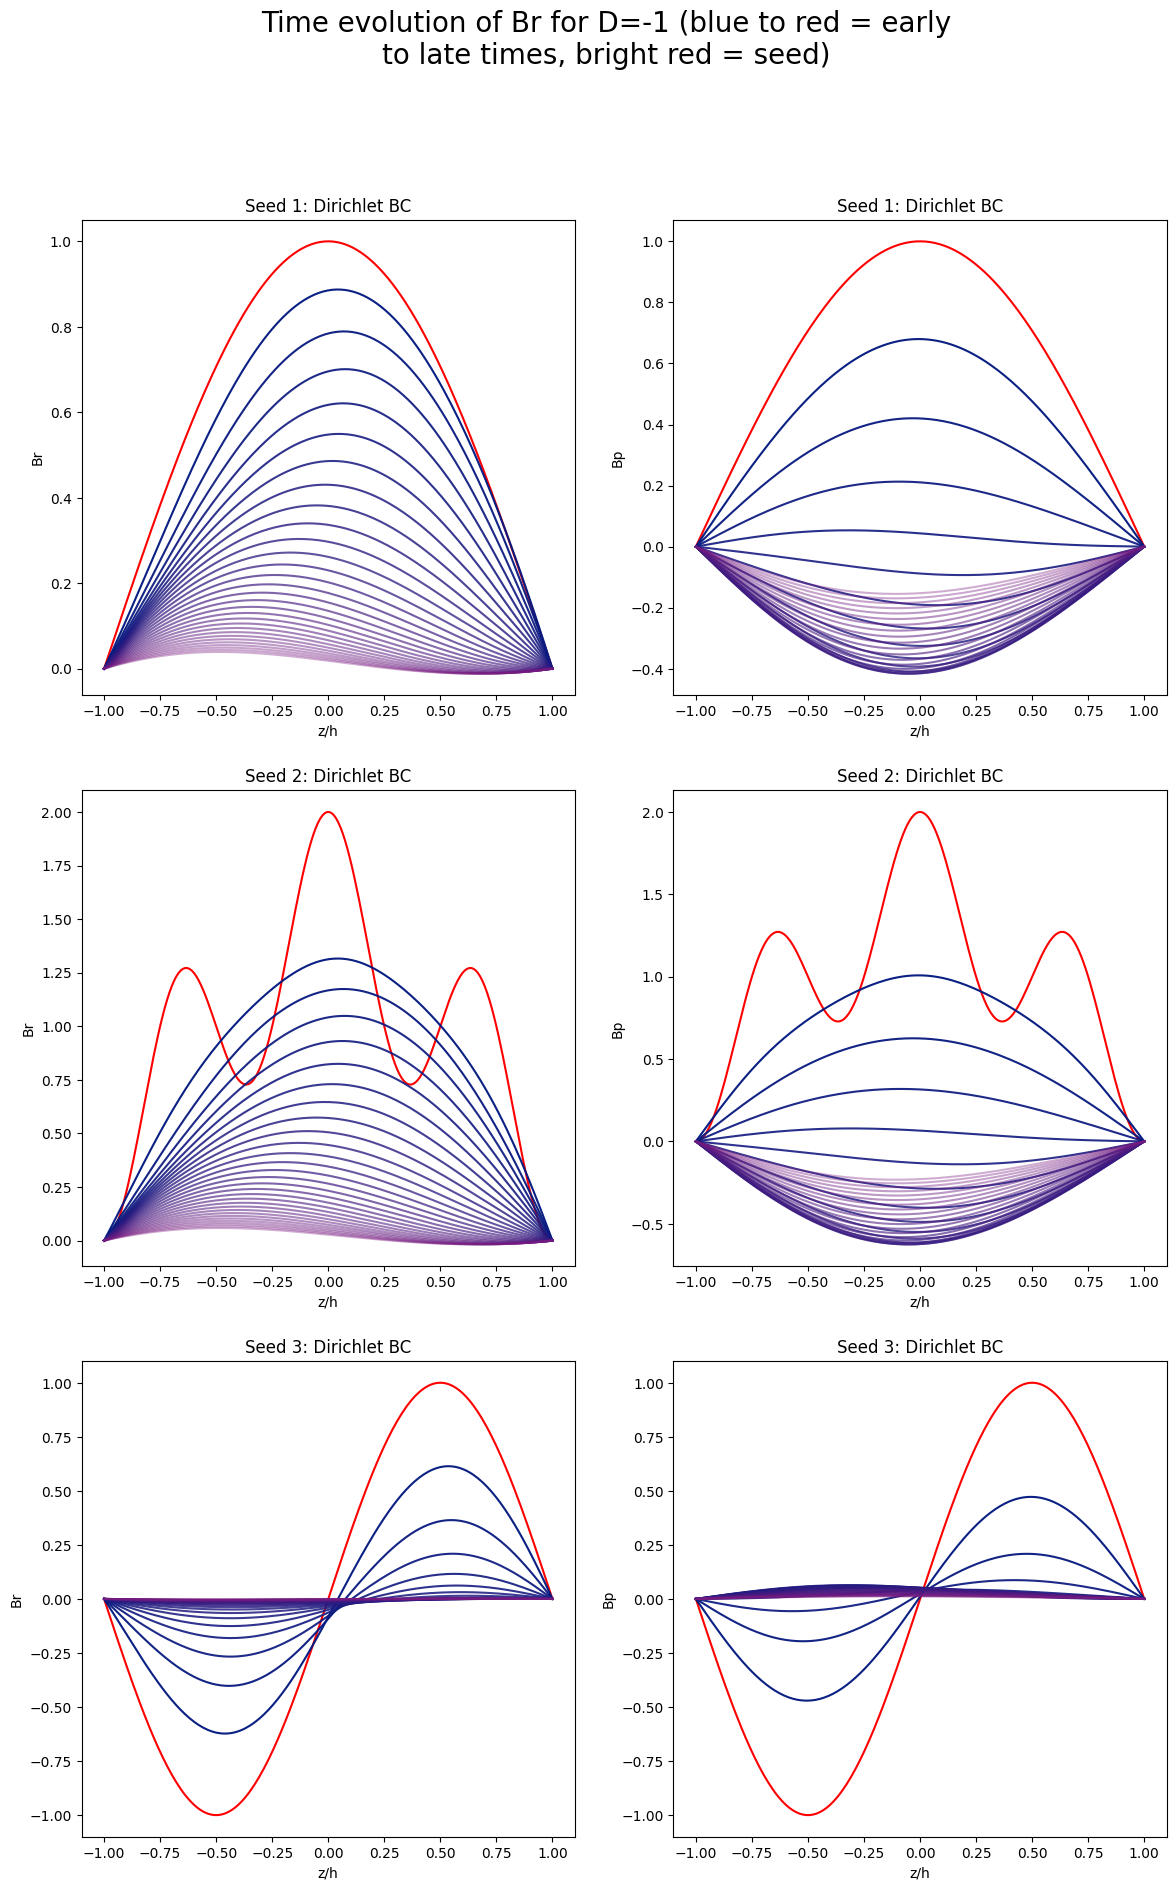

In [26]:
fig, axs = plt.subplots(3, 2, figsize = (14, 21))
i = 1000
fig.suptitle("\n".join(wrap("Time evolution of Br for D=-1 (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs[0, 0].plot(z, Br1_sol1[0], color = 'red')
axs[0, 0].set_title('Seed 1: Dirichlet BC')
axs[0, 0].set(xlabel='z/h', ylabel='Br')

axs[0, 1].plot(z, Bp1_sol1[0], color = 'red')
axs[0, 1].set_title('Seed 1: Dirichlet BC')
axs[0, 1].set(xlabel='z/h', ylabel='Bp')

axs[1, 0].plot(z, Br2_sol1[0], color = 'red')
axs[1, 0].set_title('Seed 2: Dirichlet BC')
axs[1, 0].set(xlabel='z/h', ylabel='Br')

axs[1, 1].plot(z, Bp2_sol1[0], color = 'red')
axs[1, 1].set_title('Seed 2: Dirichlet BC')
axs[1, 1].set(xlabel='z/h', ylabel='Bp')

axs[2, 0].plot(z, Br3_sol1[0], color = 'red')
axs[2, 0].set_title('Seed 3: Dirichlet BC')
axs[2, 0].set(xlabel='z/h', ylabel='Br')

axs[2, 1].plot(z, Bp3_sol1[0], color = 'red')
axs[2, 1].set_title('Seed 3: Dirichlet BC')
axs[2, 1].set(xlabel='z/h', ylabel='Bp')

while i < steps:
    axs[0, 0].plot(z, Br1_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[0, 0].set_title('Seed 1: Dirichlet BC')
    axs[0, 0].set(xlabel='z/h', ylabel='Br')

    axs[0, 1].plot(z, Bp1_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[0, 1].set_title('Seed 1: Dirichlet BC')
    axs[0, 1].set(xlabel='z/h', ylabel='Bp')

    axs[1, 0].plot(z, Br2_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[1, 0].set_title('Seed 2: Dirichlet BC')
    axs[1, 0].set(xlabel='z/h', ylabel='Br')

    axs[1, 1].plot(z, Bp2_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[1, 1].set_title('Seed 2: Dirichlet BC')
    axs[1, 1].set(xlabel='z/h', ylabel='Bp')

    axs[2, 0].plot(z, Br3_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[2, 0].set_title('Seed 3: Dirichlet BC')
    axs[2, 0].set(xlabel='z/h', ylabel='Br')

    axs[2, 1].plot(z, Bp3_sol1[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs[2, 1].set_title('Seed 3: Dirichlet BC')
    axs[2, 1].set(xlabel='z/h', ylabel='Bp')

    i += 1000

# for ax in axs.flat:
#     ax.set(xlabel='z/h', ylabel='Br')

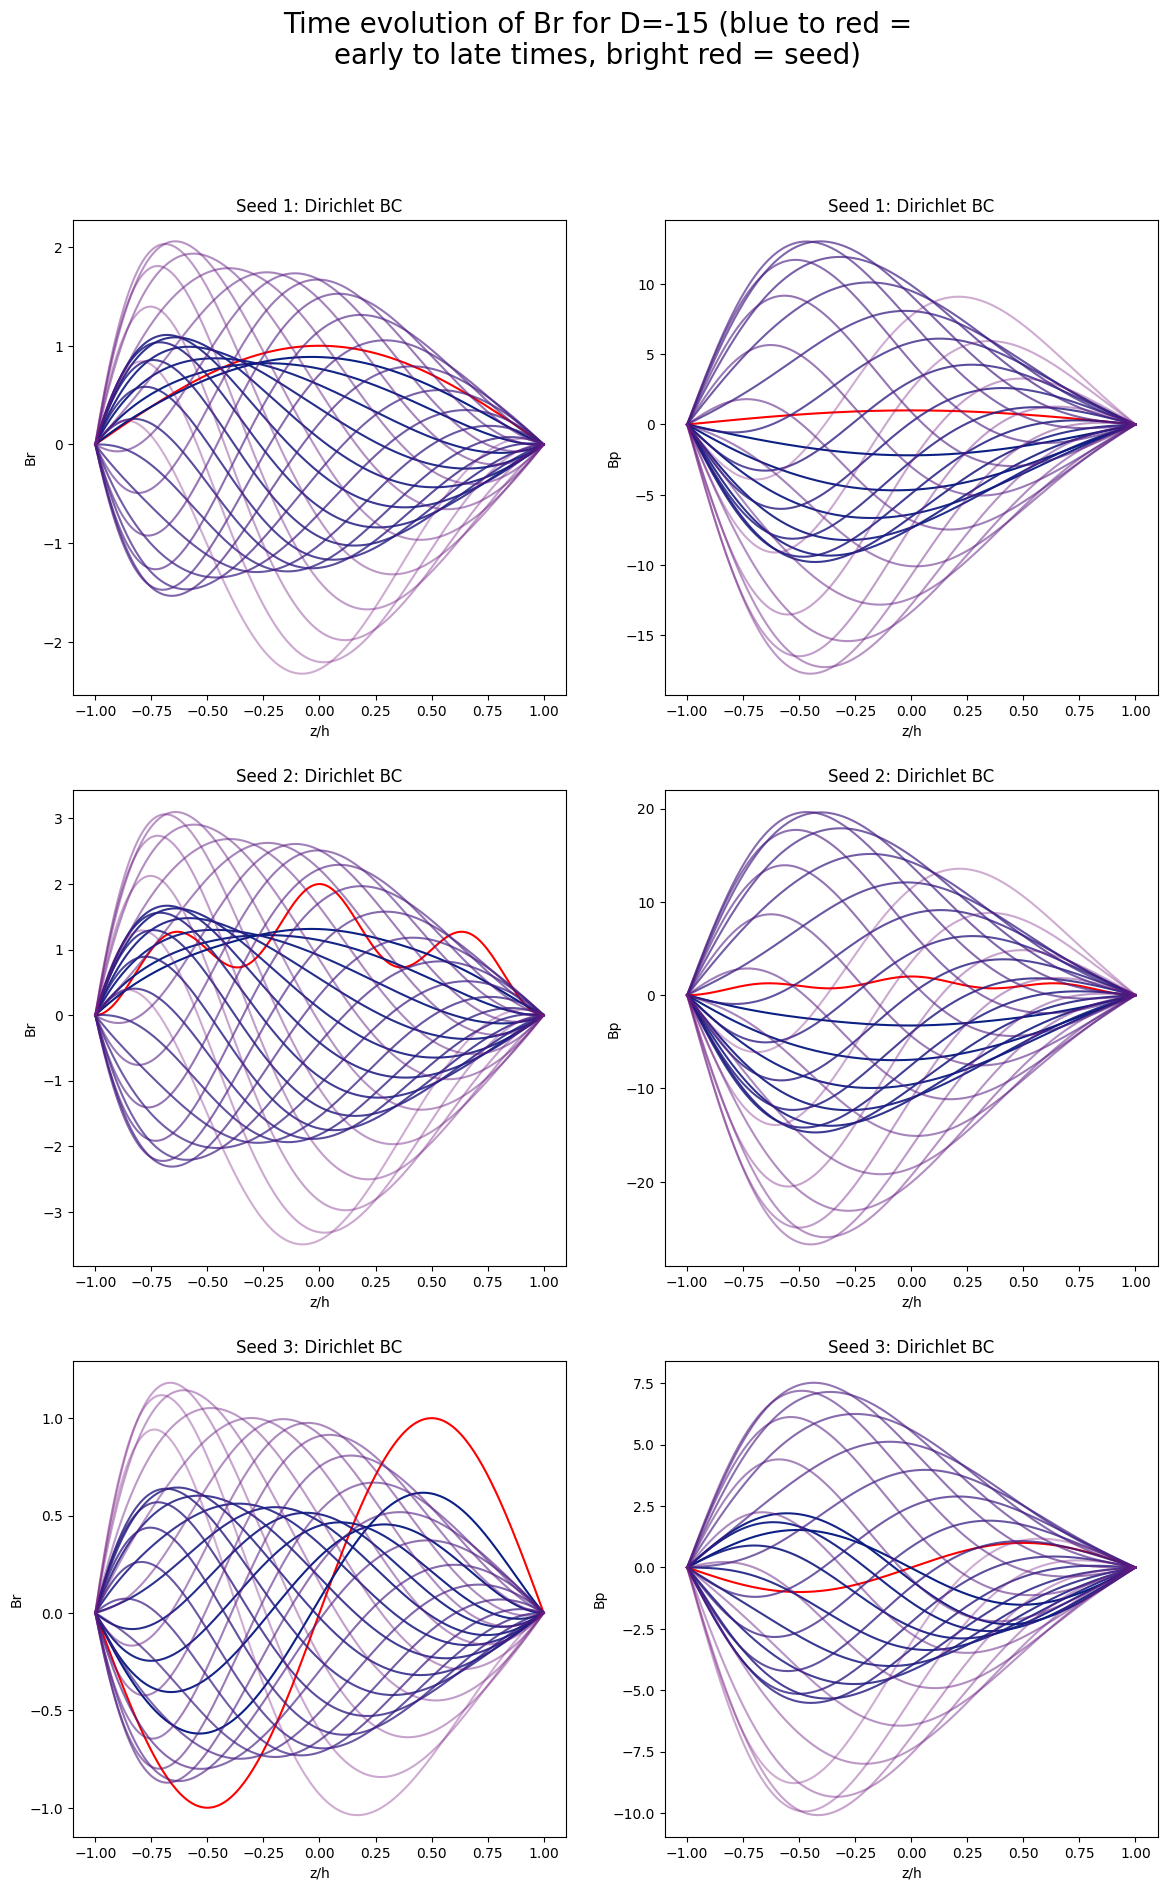

In [27]:
fig2, axs2 = plt.subplots(3, 2, figsize = (14, 21))
i = 1000
fig2.suptitle("\n".join(wrap("Time evolution of Br for D=-15 (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs2[0, 0].plot(z, Br1_sol2[0], color = 'red')
axs2[0, 0].set_title('Seed 1: Dirichlet BC')
axs2[0, 0].set(xlabel='z/h', ylabel='Br')

axs2[0, 1].plot(z, Bp1_sol2[0], color = 'red')
axs2[0, 1].set_title('Seed 1: Dirichlet BC')
axs2[0, 1].set(xlabel='z/h', ylabel='Bp')

axs2[1, 0].plot(z, Br2_sol2[0], color = 'red')
axs2[1, 0].set_title('Seed 2: Dirichlet BC')
axs2[1, 0].set(xlabel='z/h', ylabel='Br')

axs2[1, 1].plot(z, Bp2_sol2[0], color = 'red')
axs2[1, 1].set_title('Seed 2: Dirichlet BC')
axs2[1, 1].set(xlabel='z/h', ylabel='Bp')

axs2[2, 0].plot(z, Br3_sol2[0], color = 'red')
axs2[2, 0].set_title('Seed 3: Dirichlet BC')
axs2[2, 0].set(xlabel='z/h', ylabel='Br')

axs2[2, 1].plot(z, Bp3_sol2[0], color = 'red')
axs2[2, 1].set_title('Seed 3: Dirichlet BC')
axs2[2, 1].set(xlabel='z/h', ylabel='Bp')

while i < steps:
    axs2[0, 0].plot(z, Br1_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs2[0, 0].set_title('Seed 1: Dirichlet BC')
    axs2[0, 0].set(xlabel='z/h', ylabel='Br')

    axs2[0, 1].plot(z, Bp1_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs2[0, 1].set_title('Seed 1: Dirichlet BC')
    axs2[0, 1].set(xlabel='z/h', ylabel='Bp')

    axs2[1, 0].plot(z, Br2_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs2[1, 0].set_title('Seed 2: Dirichlet BC')
    axs2[1, 0].set(xlabel='z/h', ylabel='Br')

    axs2[1, 1].plot(z, Bp2_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs2[1, 1].set_title('Seed 2: Dirichlet BC')
    axs2[1, 1].set(xlabel='z/h', ylabel='Bp')

    axs2[2, 0].plot(z, Br3_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs2[2, 0].set_title('Seed 3: Dirichlet BC')
    axs2[2, 0].set(xlabel='z/h', ylabel='Br')

    axs2[2, 1].plot(z, Bp3_sol2[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs2[2, 1].set_title('Seed 3: Dirichlet BC')
    axs2[2, 1].set(xlabel='z/h', ylabel='Bp')

    i += 1000

# for ax in axs2.flat:
#     ax.set(xlabel='z/h', ylabel='Br')

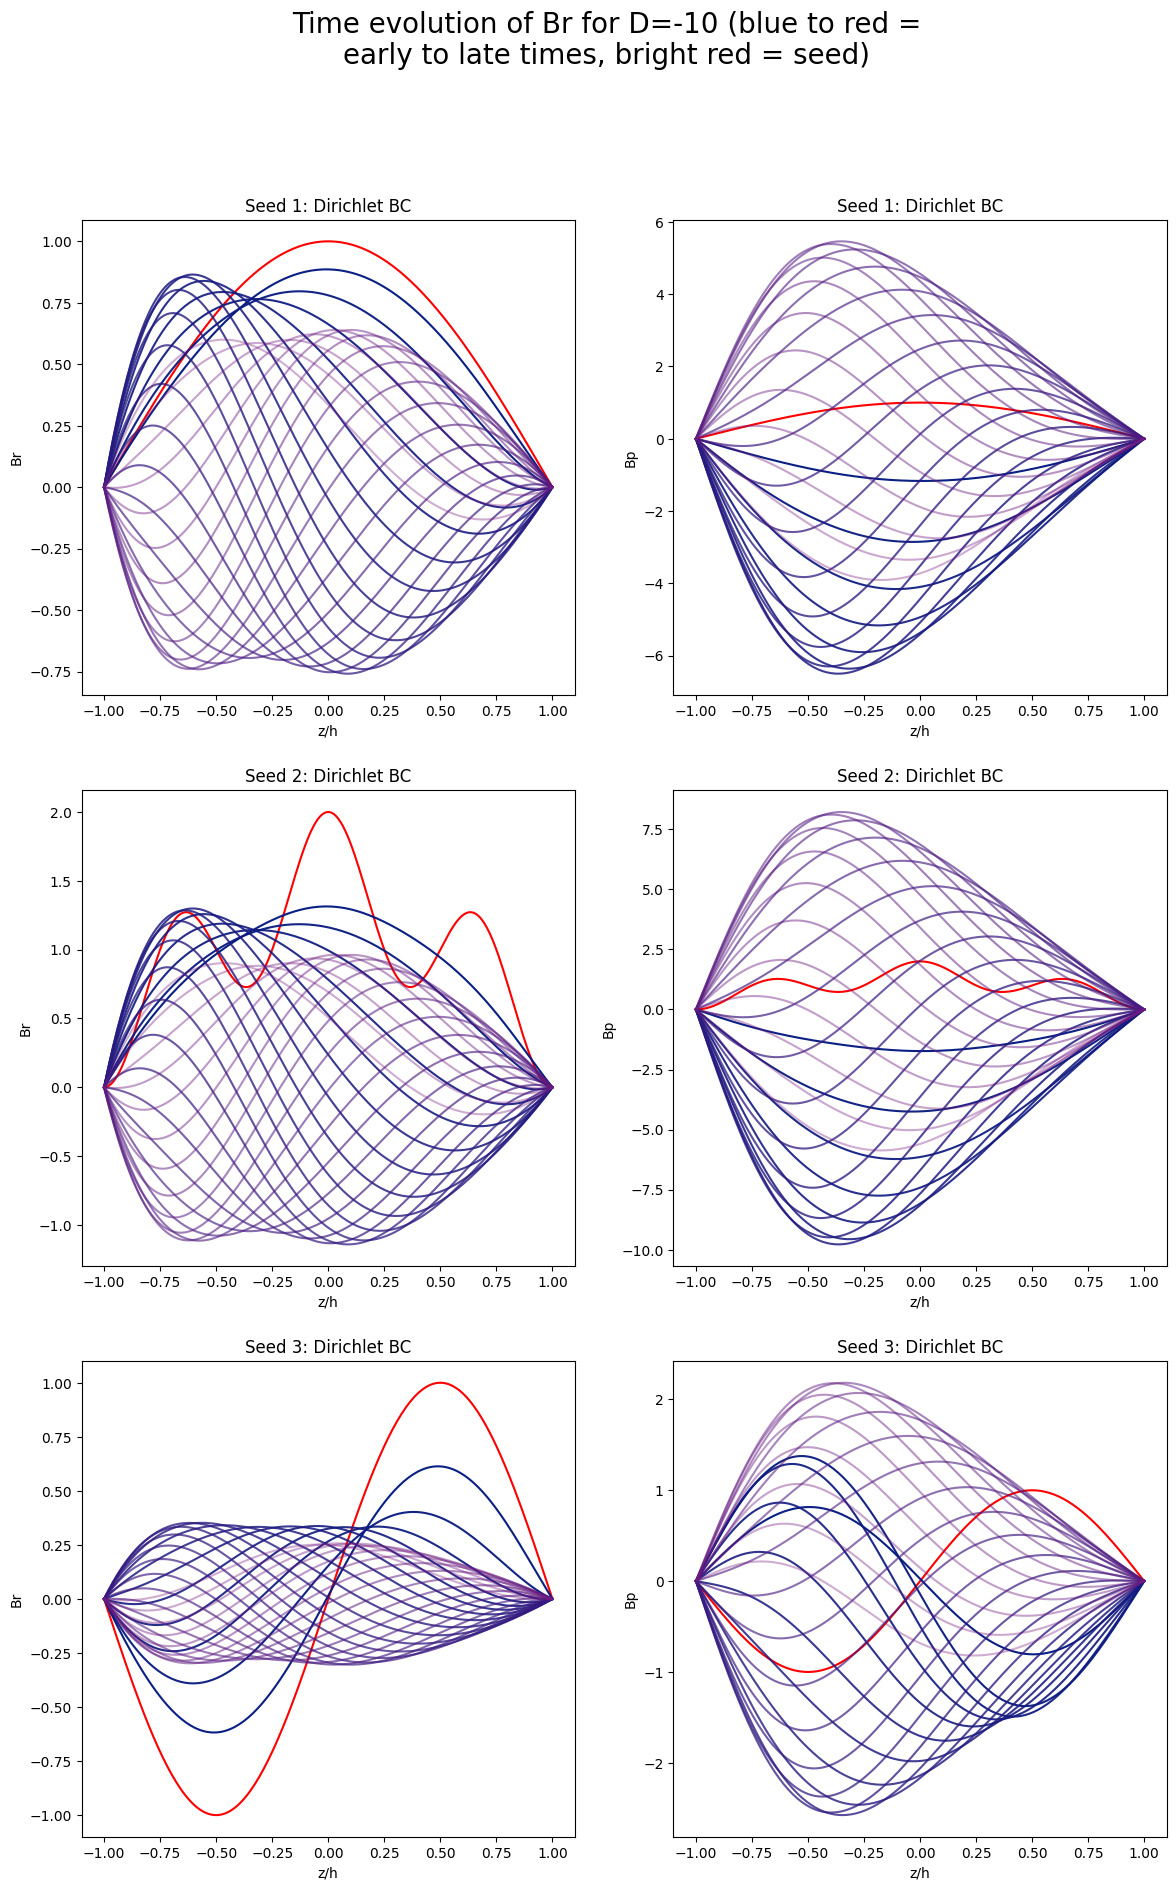

In [31]:
fig3, axs3 = plt.subplots(3, 2, figsize = (14, 21))
i = 1000
fig3.suptitle("\n".join(wrap("Time evolution of Br for D=-10 (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs3[0, 0].plot(z, Br1_sol3[0], color = 'red')
axs3[0, 0].set_title('Seed 1: Dirichlet BC')
axs3[0, 0].set(xlabel='z/h', ylabel='Br')

axs3[0, 1].plot(z, Bp1_sol3[0], color = 'red')
axs3[0, 1].set_title('Seed 1: Dirichlet BC')
axs3[0, 1].set(xlabel='z/h', ylabel='Bp')

axs3[1, 0].plot(z, Br2_sol3[0], color = 'red')
axs3[1, 0].set_title('Seed 2: Dirichlet BC')
axs3[1, 0].set(xlabel='z/h', ylabel='Br')

axs3[1, 1].plot(z, Bp2_sol3[0], color = 'red')
axs3[1, 1].set_title('Seed 2: Dirichlet BC')
axs3[1, 1].set(xlabel='z/h', ylabel='Bp')

axs3[2, 0].plot(z, Br3_sol3[0], color = 'red')
axs3[2, 0].set_title('Seed 3: Dirichlet BC')
axs3[2, 0].set(xlabel='z/h', ylabel='Br')

axs3[2, 1].plot(z, Bp3_sol3[0], color = 'red')
axs3[2, 1].set_title('Seed 3: Dirichlet BC')
axs3[2, 1].set(xlabel='z/h', ylabel='Bp')

while i < steps:
    axs3[0, 0].plot(z, Br1_sol3[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs3[0, 0].set_title('Seed 1: Dirichlet BC')
    axs3[0, 0].set(xlabel='z/h', ylabel='Br')

    axs3[0, 1].plot(z, Bp1_sol3[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs3[0, 1].set_title('Seed 1: Dirichlet BC')
    axs3[0, 1].set(xlabel='z/h', ylabel='Bp')

    axs3[1, 0].plot(z, Br2_sol3[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs3[1, 0].set_title('Seed 2: Dirichlet BC')
    axs3[1, 0].set(xlabel='z/h', ylabel='Br')

    axs3[1, 1].plot(z, Bp2_sol3[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs3[1, 1].set_title('Seed 2: Dirichlet BC')
    axs3[1, 1].set(xlabel='z/h', ylabel='Bp')

    axs3[2, 0].plot(z, Br3_sol3[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs3[2, 0].set_title('Seed 3: Dirichlet BC')
    axs3[2, 0].set(xlabel='z/h', ylabel='Br')

    axs3[2, 1].plot(z, Bp3_sol3[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs3[2, 1].set_title('Seed 3: Dirichlet BC')
    axs3[2, 1].set(xlabel='z/h', ylabel='Bp')

    i += 1000

# for ax in axs3.flat:
#     ax.set(xlabel='z/h', ylabel='Br')

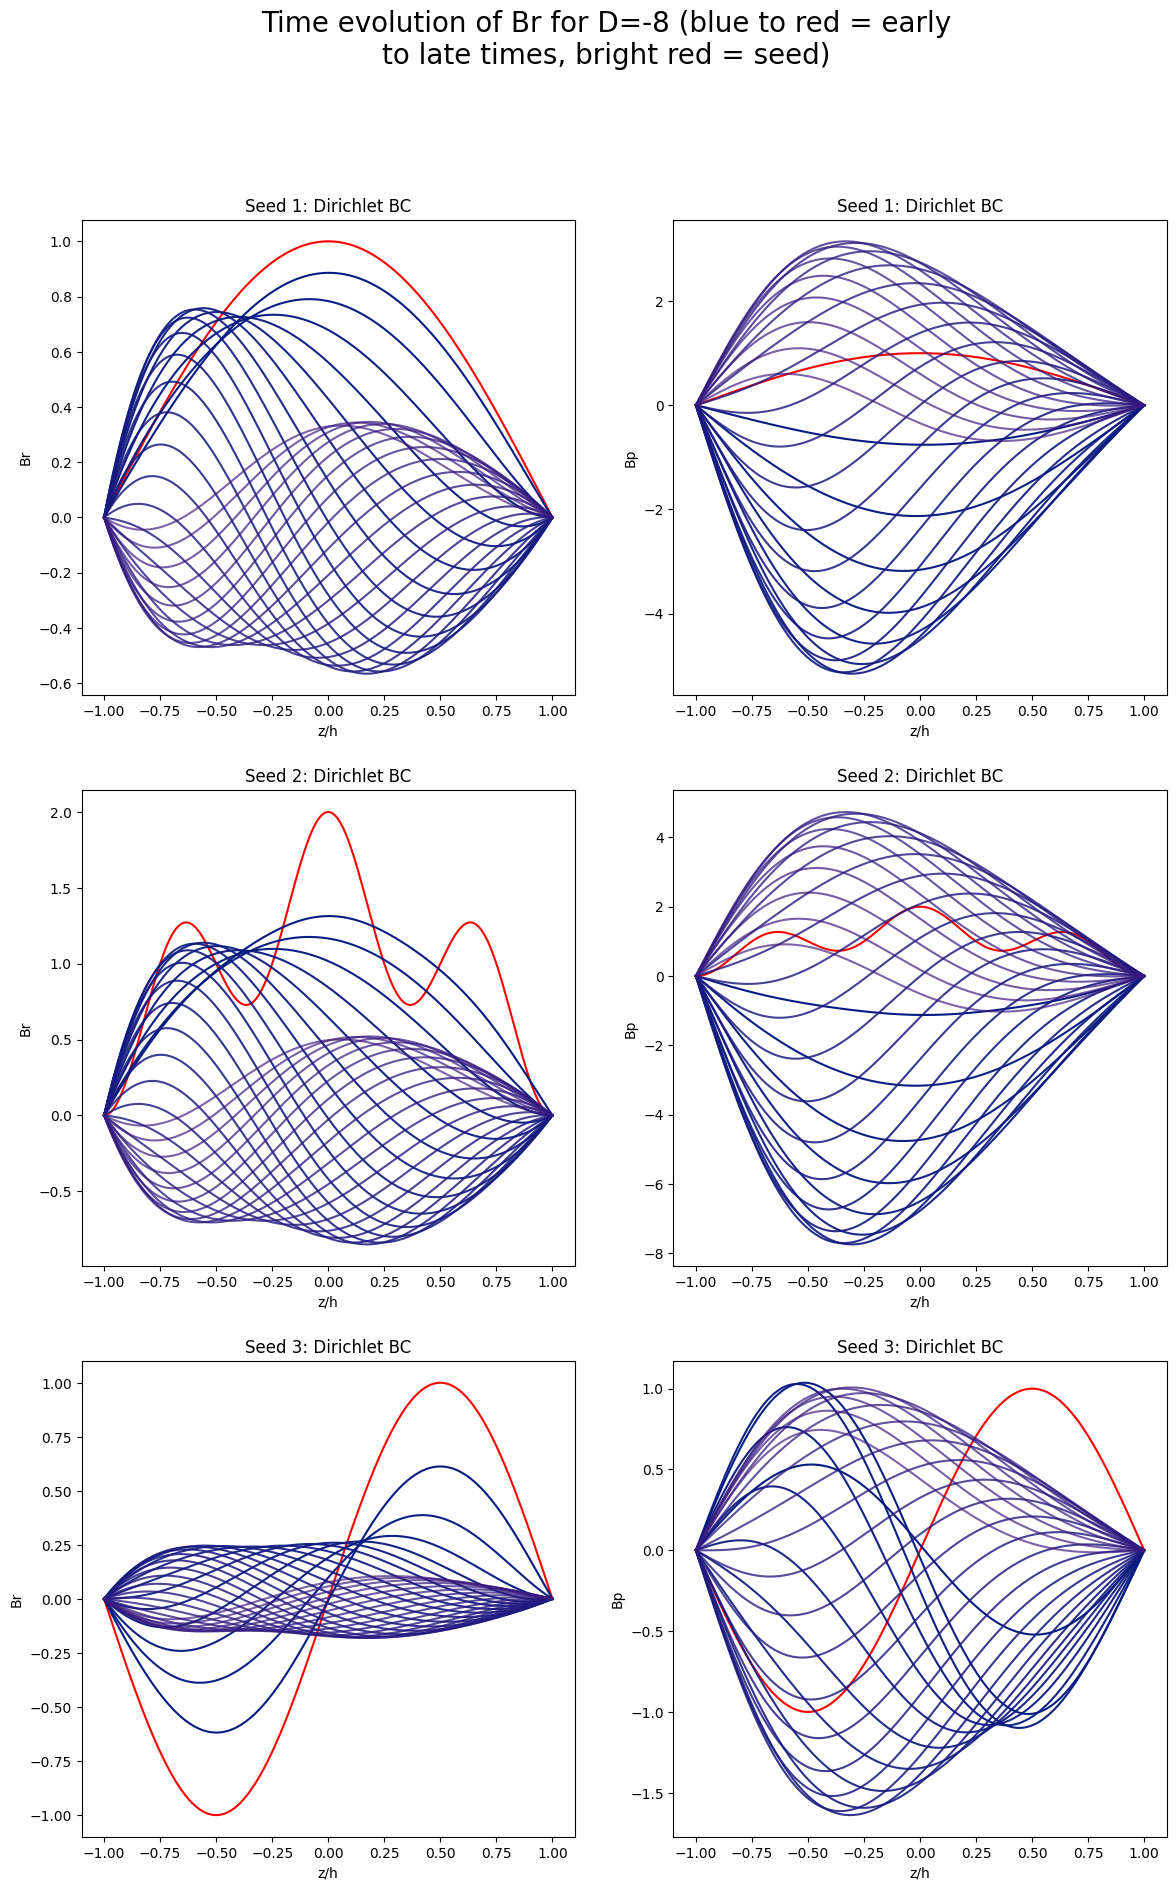

In [57]:
fig4, axs4 = plt.subplots(3, 2, figsize = (14, 21))
i = 1000
fig4.suptitle("\n".join(wrap("Time evolution of Br for D=-8 (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs4[0, 0].plot(z, Br1_sol4[0], color = 'red')
axs4[0, 0].set_title('Seed 1: Dirichlet BC')
axs4[0, 0].set(xlabel='z/h', ylabel='Br')

axs4[0, 1].plot(z, Bp1_sol4[0], color = 'red')
axs4[0, 1].set_title('Seed 1: Dirichlet BC')
axs4[0, 1].set(xlabel='z/h', ylabel='Bp')

axs4[1, 0].plot(z, Br2_sol4[0], color = 'red')
axs4[1, 0].set_title('Seed 2: Dirichlet BC')
axs4[1, 0].set(xlabel='z/h', ylabel='Br')

axs4[1, 1].plot(z, Bp2_sol4[0], color = 'red')
axs4[1, 1].set_title('Seed 2: Dirichlet BC')
axs4[1, 1].set(xlabel='z/h', ylabel='Bp')

axs4[2, 0].plot(z, Br3_sol4[0], color = 'red')
axs4[2, 0].set_title('Seed 3: Dirichlet BC')
axs4[2, 0].set(xlabel='z/h', ylabel='Br')

axs4[2, 1].plot(z, Bp3_sol4[0], color = 'red')
axs4[2, 1].set_title('Seed 3: Dirichlet BC')
axs4[2, 1].set(xlabel='z/h', ylabel='Bp')

while i < 3*10**4:
    axs4[0, 0].plot(z, Br1_sol4[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs4[0, 0].set_title('Seed 1: Dirichlet BC')
    axs4[0, 0].set(xlabel='z/h', ylabel='Br')

    axs4[0, 1].plot(z, Bp1_sol4[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs4[0, 1].set_title('Seed 1: Dirichlet BC')
    axs4[0, 1].set(xlabel='z/h', ylabel='Bp')

    axs4[1, 0].plot(z, Br2_sol4[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs4[1, 0].set_title('Seed 2: Dirichlet BC')
    axs4[1, 0].set(xlabel='z/h', ylabel='Br')

    axs4[1, 1].plot(z, Bp2_sol4[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs4[1, 1].set_title('Seed 2: Dirichlet BC')
    axs4[1, 1].set(xlabel='z/h', ylabel='Bp')

    axs4[2, 0].plot(z, Br3_sol4[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs4[2, 0].set_title('Seed 3: Dirichlet BC')
    axs4[2, 0].set(xlabel='z/h', ylabel='Br')

    axs4[2, 1].plot(z, Bp3_sol4[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs4[2, 1].set_title('Seed 3: Dirichlet BC')
    axs4[2, 1].set(xlabel='z/h', ylabel='Bp')

    i += 1000

# for ax in axs4.flat:
#     ax.set(xlabel='z/h', ylabel='Br')

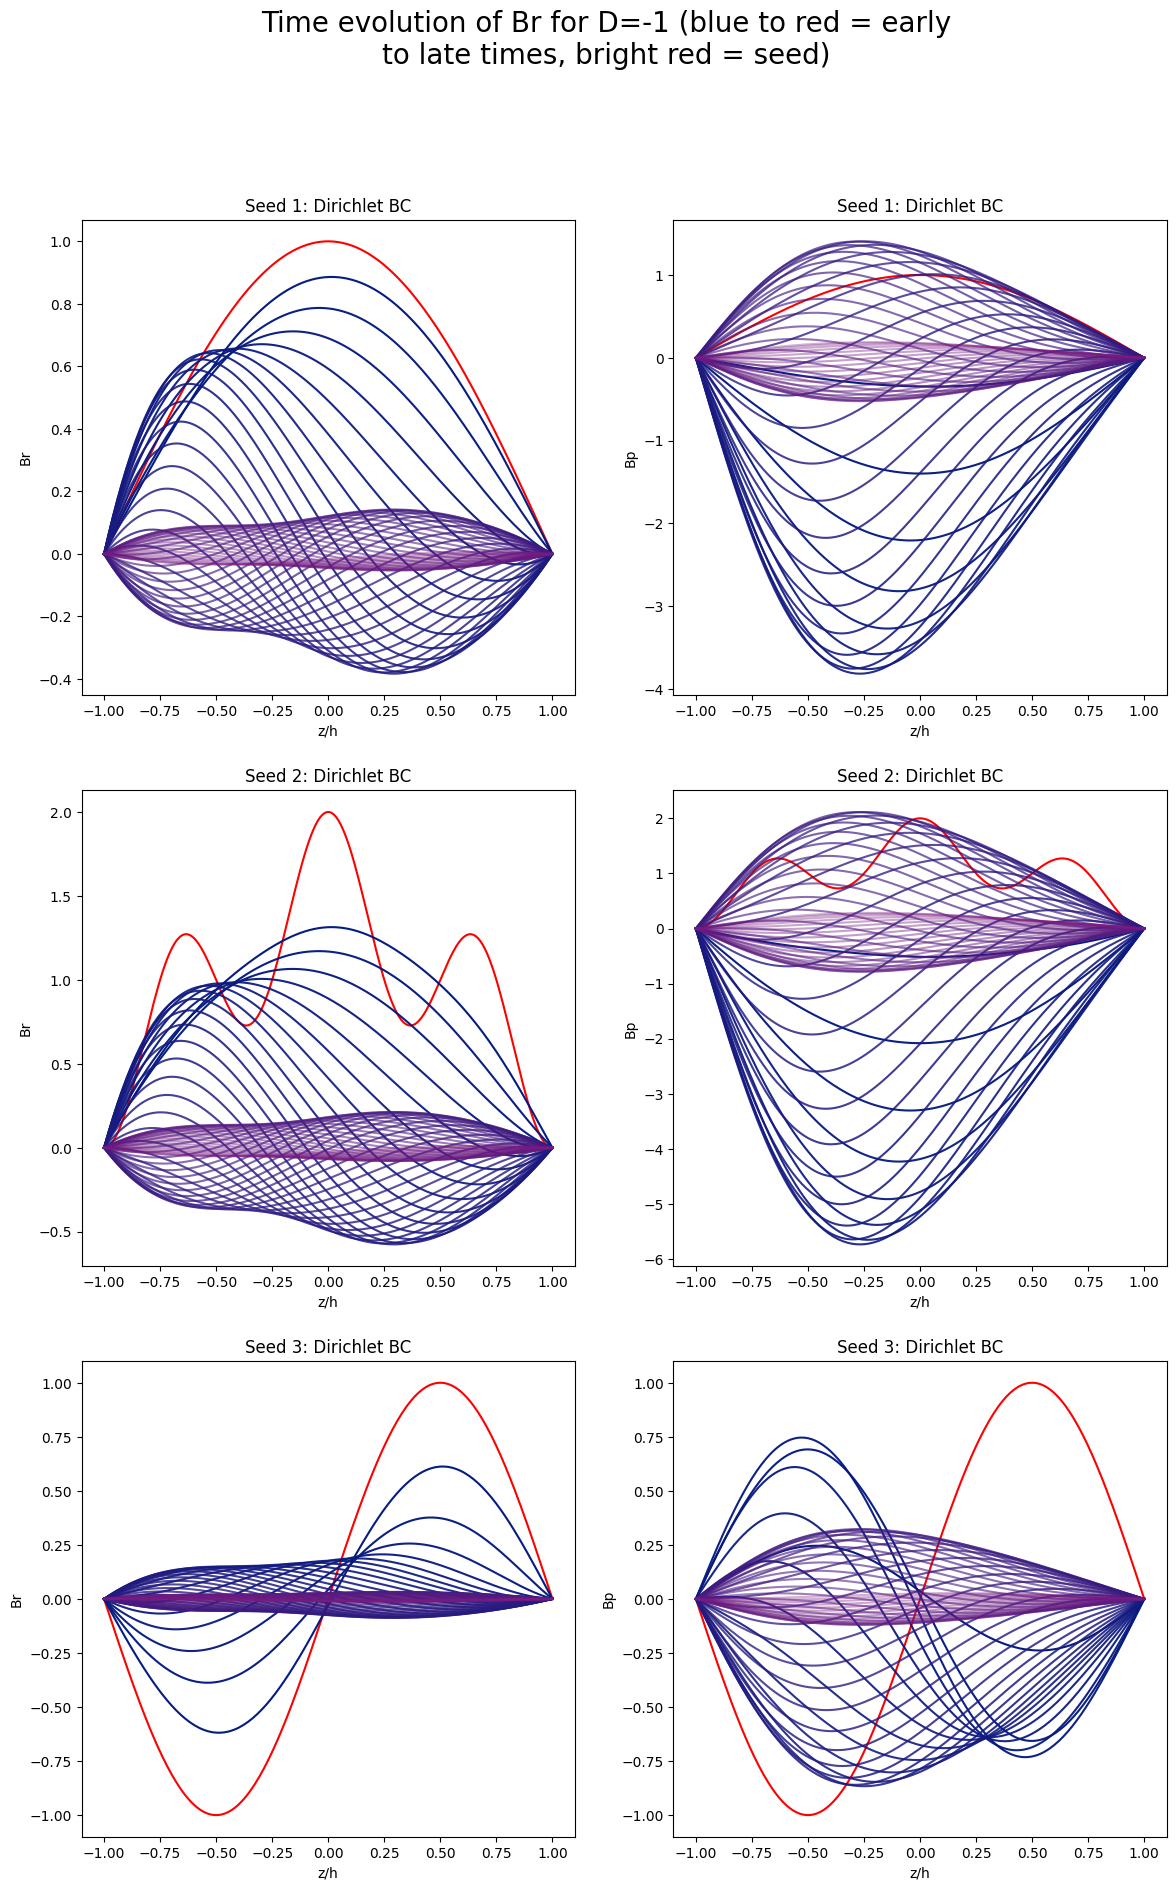

In [39]:
fig5, axs5 = plt.subplots(3, 2, figsize = (14, 21))
i = 1000
fig5.suptitle("\n".join(wrap("Time evolution of Br for D=-1 (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs5[0, 0].plot(z, Br1_sol5[0], color = 'red')
axs5[0, 0].set_title('Seed 1: Dirichlet BC')
axs5[0, 0].set(xlabel='z/h', ylabel='Br')

axs5[0, 1].plot(z, Bp1_sol5[0], color = 'red')
axs5[0, 1].set_title('Seed 1: Dirichlet BC')
axs5[0, 1].set(xlabel='z/h', ylabel='Bp')

axs5[1, 0].plot(z, Br2_sol5[0], color = 'red')
axs5[1, 0].set_title('Seed 2: Dirichlet BC')
axs5[1, 0].set(xlabel='z/h', ylabel='Br')

axs5[1, 1].plot(z, Bp2_sol5[0], color = 'red')
axs5[1, 1].set_title('Seed 2: Dirichlet BC')
axs5[1, 1].set(xlabel='z/h', ylabel='Bp')

axs5[2, 0].plot(z, Br3_sol5[0], color = 'red')
axs5[2, 0].set_title('Seed 3: Dirichlet BC')
axs5[2, 0].set(xlabel='z/h', ylabel='Br')

axs5[2, 1].plot(z, Bp3_sol5[0], color = 'red')
axs5[2, 1].set_title('Seed 3: Dirichlet BC')
axs5[2, 1].set(xlabel='z/h', ylabel='Bp')

while i < steps:
    axs5[0, 0].plot(z, Br1_sol5[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs5[0, 0].set_title('Seed 1: Dirichlet BC')
    axs5[0, 0].set(xlabel='z/h', ylabel='Br')

    axs5[0, 1].plot(z, Bp1_sol5[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs5[0, 1].set_title('Seed 1: Dirichlet BC')
    axs5[0, 1].set(xlabel='z/h', ylabel='Bp')

    axs5[1, 0].plot(z, Br2_sol5[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs5[1, 0].set_title('Seed 2: Dirichlet BC')
    axs5[1, 0].set(xlabel='z/h', ylabel='Br')

    axs5[1, 1].plot(z, Bp2_sol5[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs5[1, 1].set_title('Seed 2: Dirichlet BC')
    axs5[1, 1].set(xlabel='z/h', ylabel='Bp')

    axs5[2, 0].plot(z, Br3_sol5[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs5[2, 0].set_title('Seed 3: Dirichlet BC')
    axs5[2, 0].set(xlabel='z/h', ylabel='Br')

    axs5[2, 1].plot(z, Bp3_sol5[i], color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs5[2, 1].set_title('Seed 3: Dirichlet BC')
    axs5[2, 1].set(xlabel='z/h', ylabel='Bp')

    i += 1000

# for ax in axs5.flat:
#     ax.set(xlabel='z/h', ylabel='Br')

### From the above simulations, I think the critical dynamo number lies somewhere between -7 to -9 for alpha = 1. I performed the simulation for the -6 for a larger time to show the decay more clearly. We can see that for D < -10, the fields get amplified.

/tmp/ipykernel_41349/1302223438.py:2: RuntimeWarning: invalid value encountered in divide
  return 180*np.arctan(Bp/Br)/np.pi


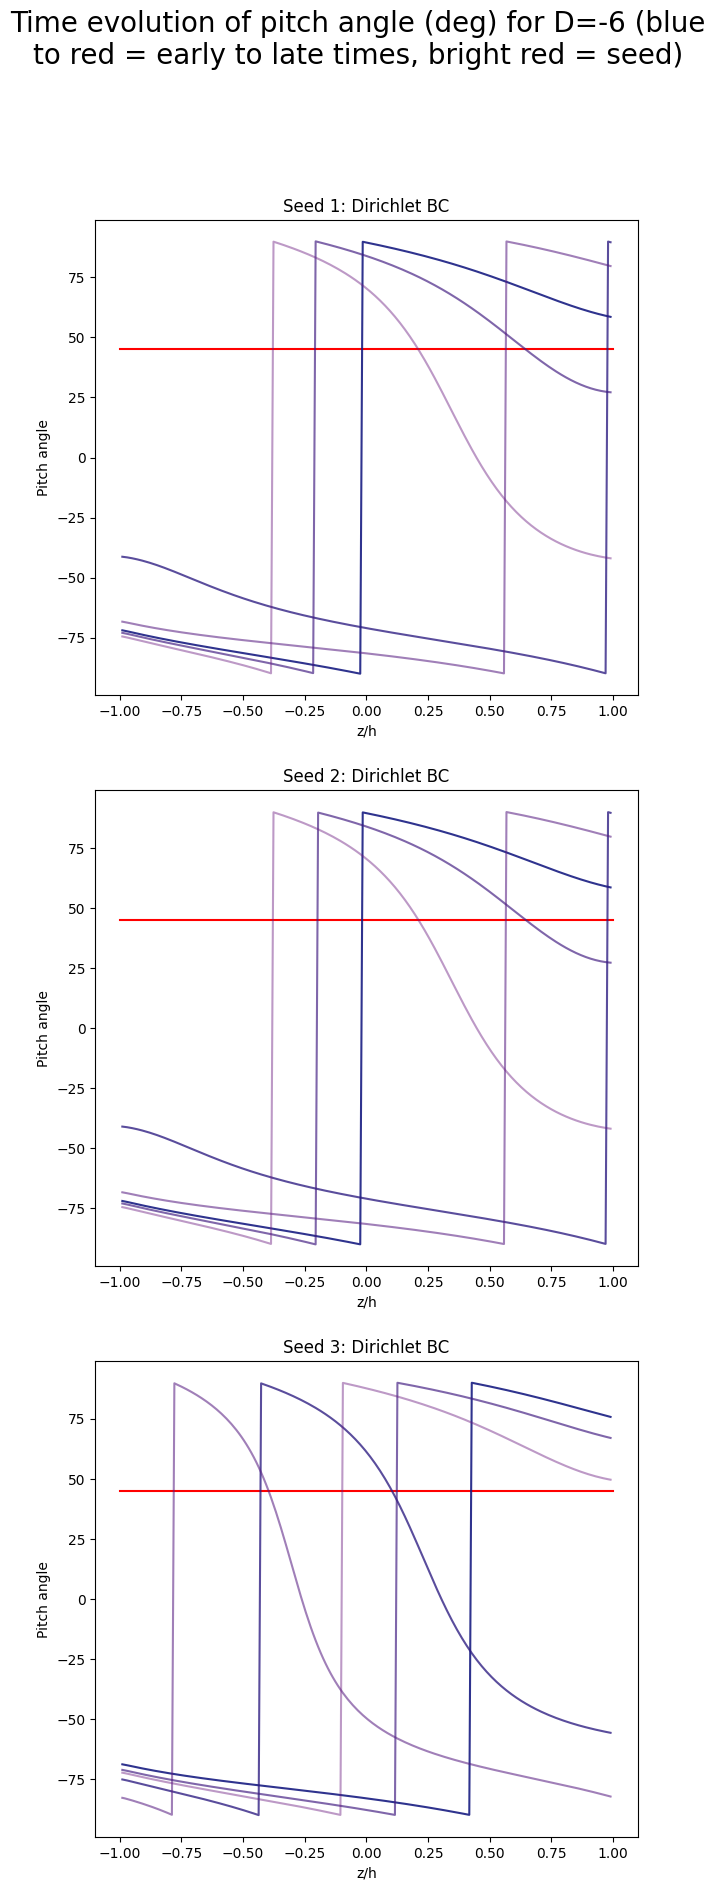

In [66]:
def pitch(Br, Bp):
    return 180*np.arctan(Bp/Br)/np.pi

i = 10000
fig6, axs6 = plt.subplots(3, 1, figsize = (7, 21))
fig6.suptitle("\n".join(wrap("Time evolution of pitch angle (deg) for D=-6 (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs6[0].plot(z, pitch(Br1_sol5[0], Bp1_sol5[0]), color = 'red')
axs6[0].set_title('Seed 1: Dirichlet BC')
axs6[0].set(xlabel='z/h', ylabel='Pitch angle')

axs6[1].plot(z, pitch(Br2_sol5[0], Bp2_sol5[0]), color = 'red')
axs6[1].set_title('Seed 2: Dirichlet BC')
axs6[1].set(xlabel='z/h', ylabel='Pitch angle')

axs6[2].plot(z, pitch(Br3_sol5[0], Bp3_sol5[0]), color = 'red')
axs6[2].set_title('Seed 3: Dirichlet BC')
axs6[2].set(xlabel='z/h', ylabel='Pitch angle')



while i < 6*10**4:
    axs6[0].plot(z, pitch(Br1_sol5[i], Bp1_sol5[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[0].set_title('Seed 1: Dirichlet BC')
    axs6[0].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[1].plot(z, pitch(Br2_sol5[i], Bp2_sol5[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[1].set_title('Seed 2: Dirichlet BC')
    axs6[1].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[2].plot(z, pitch(Br3_sol5[i], Bp3_sol5[i]), color = (round(i/(2*steps), 5), 0.1, 0.5, round(1-i/(1.5*steps), 5)))
    axs6[2].set_title('Seed 3: Dirichlet BC')
    axs6[2].set(xlabel='z/h', ylabel='Pitch angle')

    i += 10000



/tmp/ipykernel_41349/1302223438.py:2: RuntimeWarning: invalid value encountered in divide
  return 180*np.arctan(Bp/Br)/np.pi


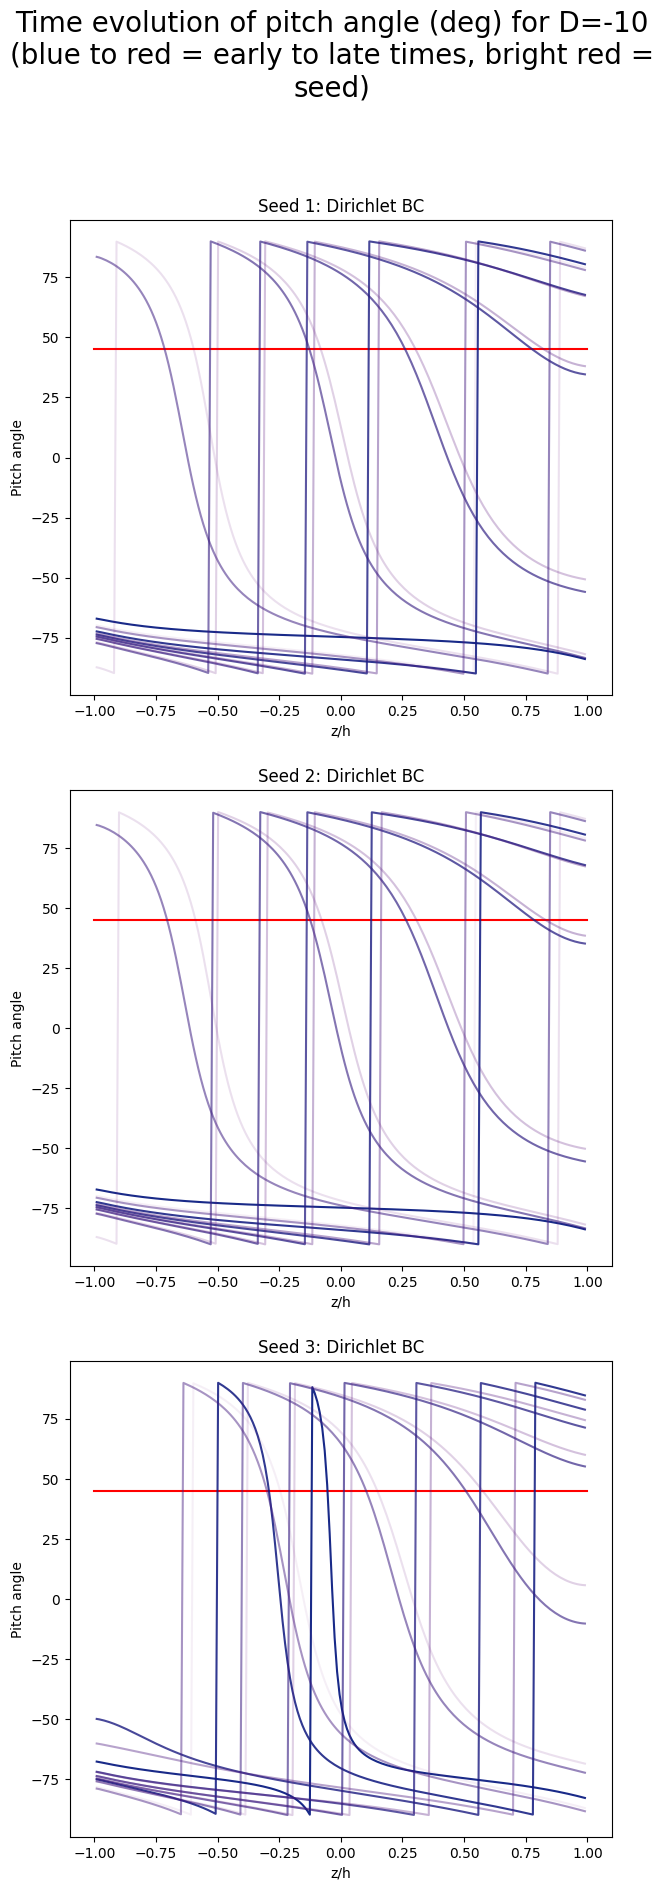

In [69]:
i = 2000
fig6, axs6 = plt.subplots(3, 1, figsize = (7, 21))
fig6.suptitle("\n".join(wrap("Time evolution of pitch angle (deg) for D=-10 (blue to red = early to late times, bright red = seed)", 50)), size = 20)

axs6[0].plot(z, pitch(Br1_sol3[0], Bp1_sol3[0]), color = 'red')
axs6[0].set_title('Seed 1: Dirichlet BC')
axs6[0].set(xlabel='z/h', ylabel='Pitch angle')

axs6[1].plot(z, pitch(Br2_sol3[0], Bp2_sol3[0]), color = 'red')
axs6[1].set_title('Seed 2: Dirichlet BC')
axs6[1].set(xlabel='z/h', ylabel='Pitch angle')

axs6[2].plot(z, pitch(Br3_sol3[0], Bp3_sol3[0]), color = 'red')
axs6[2].set_title('Seed 3: Dirichlet BC')
axs6[2].set(xlabel='z/h', ylabel='Pitch angle')



while i < 3*10**4:
    axs6[0].plot(z, pitch(Br1_sol3[i], Bp1_sol3[i]), color = (round(i/(1*steps), 5), 0.1, 0.5, round(1-i/(1*30000), 5)))
    axs6[0].set_title('Seed 1: Dirichlet BC')
    axs6[0].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[1].plot(z, pitch(Br2_sol3[i], Bp2_sol3[i]), color = (round(i/(1*steps), 5), 0.1, 0.5, round(1-i/(1*30000), 5)))
    axs6[1].set_title('Seed 2: Dirichlet BC')
    axs6[1].set(xlabel='z/h', ylabel='Pitch angle')

    axs6[2].plot(z, pitch(Br3_sol3[i], Bp3_sol3[i]), color = (round(i/(1*steps), 5), 0.1, 0.5, round(1-i/(1*30000), 5)))
    axs6[2].set_title('Seed 3: Dirichlet BC')
    axs6[2].set(xlabel='z/h', ylabel='Pitch angle')

    i += 2000


### We can see that the pitch angle is not a constant, and that it oscillates with time, and also gets closer to 45 degrees in the case of D = -6. If we continue the simulation for longer, we should see the pitch angle slowly saturate to 45 degrees.

### In the case of D = -10, since the field grows, the pitch angle doesn't necessarily have to saturate. We need to perform a longer simulation to see the effect clearly. 